In [1]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

4.3.1


# LOAD IN ALLVISIT FILE (an absolute unit: ~ 2.75GB)

In [2]:
allvis17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allVisit-dr17-synspec.fits",hdu=1, format='fits')
print(len(allvis17['APOGEE_ID']))
print(allvis17.columns)

2659178
<TableColumns names=('APOGEE_ID','TARGET_ID','VISIT_ID','FILE','FIBERID','CARTID','PLATE','MJD','TELESCOPE','SURVEY','FIELD','PROGRAMNAME','ALT_ID','LOCATION_ID','RA','DEC','GLON','GLAT','RELFLUX','MTPFLUX','J','J_ERR','H','H_ERR','K','K_ERR','SRC_H','WASH_M','WASH_M_ERR','WASH_T2','WASH_T2_ERR','DDO51','DDO51_ERR','IRAC_3_6','IRAC_3_6_ERR','IRAC_4_5','IRAC_4_5_ERR','IRAC_5_8','IRAC_5_8_ERR','IRAC_8_0','IRAC_8_0_ERR','WISE_4_5','WISE_4_5_ERR','TARG_4_5','TARG_4_5_ERR','WASH_DDO51_GIANT_FLAG','WASH_DDO51_STAR_FLAG','PMRA','PMDEC','PM_SRC','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE_TARGET4','TARGFLAGS','SNR','STARFLAG','STARFLAGS','DATEOBS','JD','VLSR','VGSR','CHISQ','SYNTHFILE','MIN_H','MAX_H','MIN_JK','MAX_JK','VREL','VRELERR','VHELIO','BC','RV_TEFF','RV_LOGG','RV_FEH','RV_CARB','RV_ALPHA','XCORR_VREL','XCORR_VRELERR','XCORR_VHELIO','CCFWHM','AUTOFWHM','RV_CHI2','N_COMPONENTS','RV_COMPONENTS','RV_FLAG')>


#### Load in relevant cross-matches and grab Joker Params for specific TIC ID

In [210]:
target_tic = 'TIC 20215452'

#cross-matched star table (has source_id, apogee_id, TIC_id)
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3.fits', format='fits')
print(hq_jk_allstar_tess_edr3.columns)

#Adrian's calibrated RV_ERRs
calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-calib-verr.fits', format='fits', hdu=1)

# Grab cross-match IDs
jk_row = hq_jk_allstar_tess_edr3[hq_jk_allstar_tess_edr3['ID'] == int(target_tic.split(' ')[1])]


sysapodat = allvis17[allvis17['APOGEE_ID'] == jk_row['APOGEE_ID']]

## joining calib RV_ERRs with the RVs
sysapodat = astab.join(sysapodat, calibverr, keys=('VISIT_ID','VISIT_ID'))



<TableColumns names=('APOGEE_ID','n_visits','MAP_P','MAP_P_err','MAP_e','MAP_e_err','MAP_omega','MAP_omega_err','MAP_M0','MAP_M0_err','MAP_K','MAP_K_err','MAP_v0','MAP_v0_err','MAP_s','MAP_s_err','MAP_t0_bmjd','t_ref_bmjd','baseline','MAP_ln_likelihood','MAP_ln_prior','max_unmarginalized_ln_likelihood','max_phase_gap','periods_spanned','phase_coverage','phase_coverage_per_period','unimodal','joker_completed','mcmc_completed','mcmc_status','gelman_rubin_max','constant_ln_likelihood','robust_constant_ln_likelihood','robust_constant_mean','robust_constant_scatter','robust_constant_success','robust_linear_ln_likelihood','robust_linear_a','robust_linear_b','robust_linear_scatter','robust_linear_success','FILE','TELESCOPE','LOCATION_ID','FIELD','RA','DEC','J','H','K','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','APOGEE2_TARGET4','NVISITS','SNR','STARFLAG','ANDFLAG','VHELIO_AVG','VSCATTER','VERR','N_COMPONENTS','GAIAEDR3_SOURCE_ID','GAIAEDR3_PARALLAX

In [211]:
print(jk_row['MAP_t0_bmjd']-sysapodat['MJD'].min())

    MAP_t0_bmjd     
--------------------
-0.42188601367524825


   MAP_t0_bmjd    
------------------
56701.578113986325       MAP_P      
        d        
-----------------
3.067790985107422


'plot multiple tic ids with folded lightcurves and RVs using the BLS period/t0 from the TESS data\n'

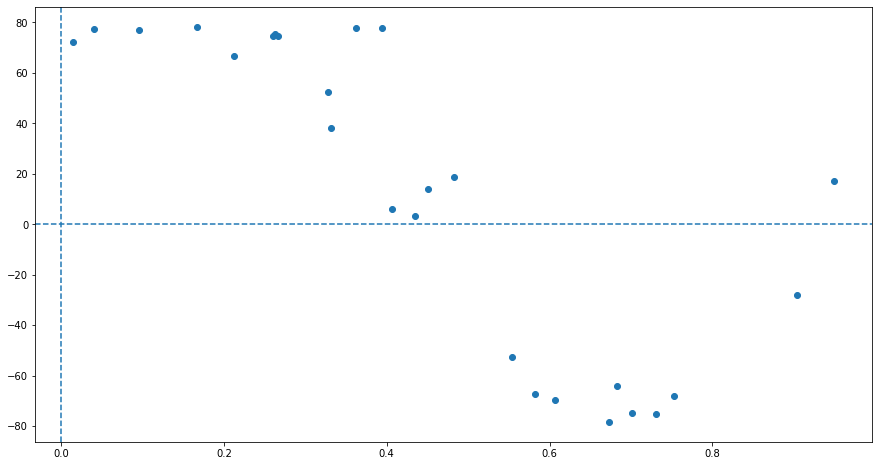

In [212]:
#### DEFINE THE RV,RV_ERRs, and X_RVs for later use in the mcmc... DO NOT REDEFINE ME OR YOU MAKE PYMC3 SAD
x_rv = sysapodat['JD'] 
xrv_sorted_ind = np.argsort(x_rv)

x_rv = x_rv[xrv_sorted_ind]
y_rv = sysapodat['VHELIO'][xrv_sorted_ind]
yerr_rv = sysapodat['CALIB_VERR'][xrv_sorted_ind]

map_t0_bmjd = jk_row['MAP_t0_bmjd']
t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')
t0_bjd = t0_bmjd.tcb.jd

fit,ax = plt.subplots(nrows=1, figsize=(15,8))
print(jk_row['MAP_t0_bmjd'], jk_row['MAP_P'])
# ax.scatter((x_rv - (1901.7952219793171+2457000.) + 0.5 * 7.689283720758311) % 7.689283720758311 - 0.5 * 7.689283720758311, y_rv-jk_row['MAP_v0'],)
ax.scatter(((x_rv - (1901.7952219793171+2457000.)) % 3.067790985107422)/ 3.067790985107422, y_rv-jk_row['MAP_v0'],)
ax.axhline(0.0,ls='--')
ax.axvline(0.0,ls='--')
# 7.689283720758311 d 1901.7952219793171
# ax.scatter((x_rv-min(x_rv))%jk_row['MAP_P'], y_rv)
# ax.scatter(((x_rv -min(x_rv) + 0.5*jk_row['MAP_P']) % jk_row['MAP_P']) - 0.5 * jk_row['MAP_P'], y_rv)

"""plot multiple tic ids with folded lightcurves and RVs using the BLS period/t0 from the TESS data
"""

In [196]:
target_lk = lk.search_lightcurve(target_tic,
             mission='TESS',
            cadence='short',
            author='SPOC'
             )
print(target_lk)
unpro_lks = target_lk.download_all(quality_bitmask='hardest')
lks = unpro_lks[0].remove_nans().normalize()


SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 24 2020   SPOC     120    20215452      0.0


In [197]:
with fits.open(unpro_lks[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
print(texp, texp*60*60*24)



0.001388888888888889 120.00000000000003


In [198]:
print(lks)

       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
------------------ -------------- ... -------------- --------------
1955.7991026548211  1.0041075e+00 ... -2.7021444e-03 -9.4684437e-02
1955.8004915407635  1.0060863e+00 ...  5.1837163e-03 -9.3525924e-02
 1955.801880426706  1.0118850e+00 ...  4.2631707e-04 -8.6544067e-02
1955.8032693128814  1.0099280e+00 ...  4.8555005e-03 -8.8789538e-02
1955.8046581988237  1.0103210e+00 ... -3.2113071e-03 -8.9989230e-02
 1955.806047084766  1.0119865e+00 ...  1.0102710e-02 -9.5224857e-02
               ...            ... ...            ...            ...
1982.2752307537887  1.0450741e+00 ... -1.4284671e-03 -2.1512792e-02
1982.2766196106274  1.0445591e+00 ... -2.4617512e-03 -1.6306780e-02
1982.2780084674662  1.0511358e+00 ... -3.6010086e-03 -1.8041817e-02
 1982.279397324305  1.0540247e+00 ... -2.3698937e-03 -1.7726080e-02
  1982.28078618091  1.0482491e+00 ...  2.3492899

In [199]:
# lks = ppt_flux.remove_nans()  #[lks.remove_nans()]
# lks = lks.remove_outliers(sigma_lower=10**6)
period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
star1_bls = lks.to_periodogram('bls',
                                period=period_grid,
                                frequency_factor = 2000, duration=np.linspace(0.001,0.09,100))
star1_per = star1_bls.period_at_max_power
star1_t0 = star1_bls.transit_time_at_max_power
star1_dur = star1_bls.duration_at_max_power
star1_depth = star1_bls.depth_at_max_power
print(star1_per, star1_t0, star1_dur, star1_depth)

0.29817722900196725 d 1955.9806526548211 0.0621 d 0.08838226128502946


#### manual smoothing and outlier removal per the RV-TRANSIT model example page

In [200]:
star1_mask = lks.create_transit_mask(period=star1_per.value, 
                                     duration=3.*star1_dur.value, 
                                     transit_time=star1_t0.value,
                                    )

In [201]:
period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
star2_lks = lks[~star1_mask]
star2_bls = star2_lks.to_periodogram('bls',
                                period=period_grid,
                                frequency_factor = 2000, duration=np.linspace(0.001,0.09,100))
star2_per = star2_bls.period_at_max_power
star2_t0 = star2_bls.transit_time_at_max_power
star2_dur = star2_bls.duration_at_max_power
star2_depth = star2_bls.depth_at_max_power
print(star2_per, star2_t0, star2_dur, star2_depth)
lks_ref = min(lks.time.value)
print(star1_per - star2_per)

0.5953533130814371 d 1955.864402654821 0.09000000000000001 d 0.07556237154605232
-0.2971760840794699 d


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

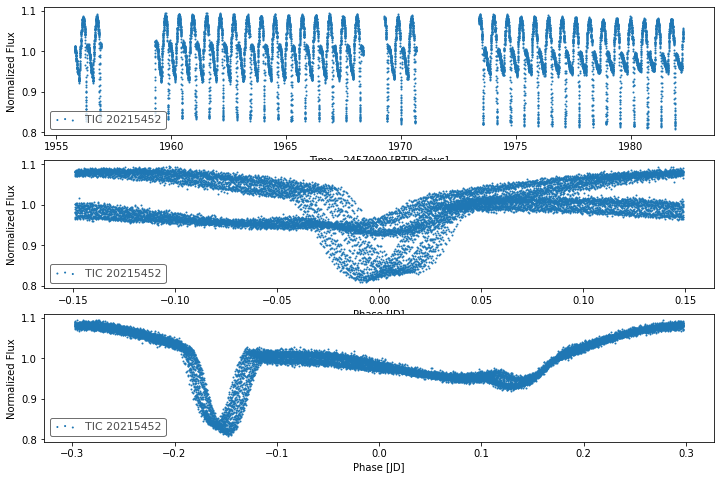

In [202]:
fig,ax = plt.subplots(nrows=3,figsize=(12,8))
lks.scatter(ax=ax[0])
lks.fold(period=star1_per, epoch_time=star1_t0).scatter(ax=ax[1])
lks.fold(period=star2_per, epoch_time=star2_t0).scatter(ax=ax[2])

0.5953533130814371 d 1956.303802654821 0.040600000000000004 d 0.09546146130257194
-0.2971760840794699 d -0.32315000000000005 0.0215 d


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

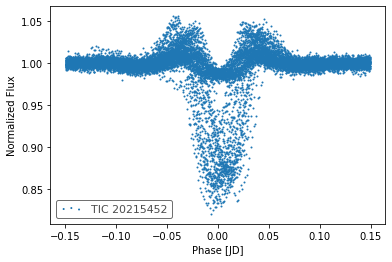

In [205]:
lks2 = unpro_lks[0].remove_nans().normalize().flatten()
period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
star1_bls_noflat = lks2.to_periodogram('bls',
                                period=period_grid,
                                frequency_factor = 2000, duration=np.linspace(0.001,0.09,10))
star1_per_nf = star1_bls_noflat.period_at_max_power
star1_t0_nf = star1_bls_noflat.transit_time_at_max_power
star1_dur_nf = star1_bls_noflat.duration_at_max_power
star1_depth_nf = star1_bls_noflat.depth_at_max_power
print(star1_per_nf, star1_t0_nf, star1_dur_nf, star1_depth_nf)
print(star1_per-star1_per_nf, star1_t0-star1_t0_nf, star1_dur-star1_dur_nf)
fig,ax = plt.subplots(nrows=1)
lks2.fold(period=star1_per, epoch_time=star1_t0).scatter(ax=ax)

In [14]:
primary_phase = lks2.time.value[np.argmin(lks2.flux.value)]%star1_per.value
secondary_phase = star2_lks.time.value[np.argmin(star2_lks.flux.value)]%star2_per.value
print(primary_phase, secondary_phase)

2.537147350756868 3.1835600053826214


lightcurve N datapoints:  3011 3011 3011 transit_epoch:  0.18155000000001564


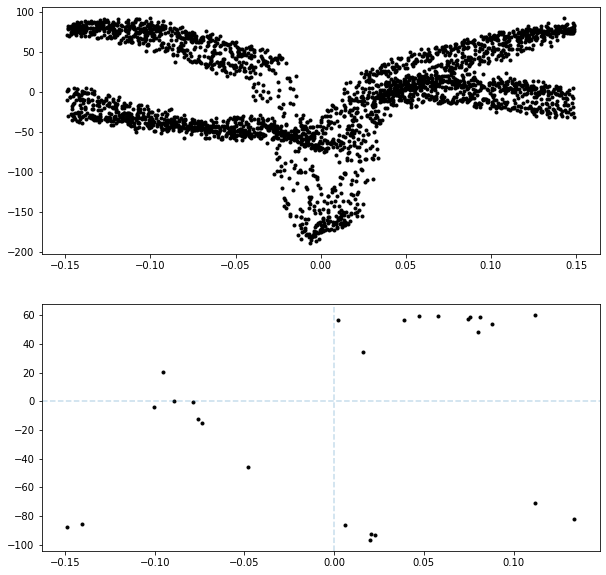

In [209]:

# sorted_xrv_ind = np.argsort(sysapodat['JD'])
# x_rv = sysapodat['JD'][sorted_xrv_ind]

# y_rv = sysapodat['VHELIO'][sorted_xrv_ind]
# yerr_rv = sysapodat['CALIB_VERR'][sorted_xrv_ind]
# print("#"*60)

# periods = [star1_per.value, star2_per.value]
# t0s = [star1_t0.value, star2_t0.value]
# t0s_jd = [star1_t0.value, star2_t0.value]
# durations = [star1_dur.value, star2_dur.value]
# depths = [star1_depth.value, star2_depth.value]
    
    
x = lks.time.btjd
y = lks.flux.value
yerr = lks.flux_err.value
x_lk_ref = min(x)

map_t0_bmjd = jk_row['MAP_t0_bmjd']
t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')
t0_bjd = t0_bmjd.tcb.jd

x_rv = x_rv  - 2457000 - x_lk_ref

x = x - x_lk_ref 
y = (y / np.median(y) - 1)

y *= 1e3

bls_period = star1_per.value
bls_t0 = star1_t0.value           -      x_lk_ref
bls_depth = star1_depth.value


def run_with_sparse_data(x,y,yerr, use_sparse_data=False):
    if use_sparse_data:
        np.random.seed(68594)
        m = np.random.rand(len(x)) < 1.0 / 5
        x = x[m]
        y = y[m]
        yerr = yerr[m]
    return x,y,yerr

x,y,yerr = run_with_sparse_data(x,y,yerr,True)
print('lightcurve N datapoints: ',len(x),len(y),len(yerr), 'transit_epoch: ',bls_t0)

period_2stars = [star1_per.value, star2_per.value]
t0_2stars = [star1_t0.value - x_lk_ref, star2_t0.value - x_lk_ref]
depth_2stars = [star1_depth.value, star2_depth.value]

x = np.ascontiguousarray(x, dtype=np.float64)
y = np.ascontiguousarray(y, dtype=np.float64)
yerr = np.ascontiguousarray(yerr, dtype=np.float64)


x_rv = np.ascontiguousarray(x_rv, dtype=np.float64)
y_rv = np.ascontiguousarray(y_rv, dtype=np.float64)
yerr_rv = np.ascontiguousarray(yerr_rv, dtype=np.float64)

lit_period = star1_per.value
lit_t0 = star1_t0.value - x_lk_ref
fig,axes = plt.subplots(nrows=2, figsize=(10,10))

axes[0].plot(
    ((x - lit_t0 + 0.5 * lit_period) % lit_period) - 0.5 * lit_period, y, ".k"
)
axes[1].plot(
    ((x_rv - lit_t0 + 0.5 * lit_period) % lit_period) - 0.5 * lit_period, y_rv, ".k")

np.all(x_rv[1:] - x_rv[:-1] > 0.0)
axes[1].axvline(0.0,ls='--',alpha=0.25)
axes[1].axhline(0.0,ls='--',alpha=0.25)

In [149]:
alpha_params = np.linspace(0.1,2.0,10)
beta_params = np.linspace(1.0,20.0,10)

In [160]:

def build_model(mask=None, start=None, lc_gp_params=[0.1, 5.0]):
    if mask is None:
        mask = np.ones(len(x), dtype='bool')
    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=10.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)

        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        log_M1 = pm.Normal("log_M1", mu=0.0, sigma=10.0)
#         log_R1 = pm.Uniform('log_R1', lower=np.log(1e-5), upper=np.log(1000))
        log_R1 = pm.Normal("log_R1", mu=0.0, sigma=10.0)
        M1 = pm.Deterministic("M1", tt.exp(log_M1))
        R1 = pm.Deterministic("R1", tt.exp(log_R1))

        # Secondary ratios
        log_k = pm.Normal("log_k", mu=0.0, sigma=20.0)  # radius ratio
        log_q = pm.Normal("log_q", mu=0.0, sigma=20.0)  # mass ratio
        log_s = pm.Normal("log_s", mu=0.0, sigma=20.0)  # surface brightness ratio
        pm.Deterministic("k", tt.exp(log_k))
        pm.Deterministic("q", tt.exp(log_q))
        pm.Deterministic("s", tt.exp(log_s))

        # Prior on flux ratio
        pm.Normal(
            "flux_prior",
            mu=0.5,
            sigma=0.25,
            observed=tt.exp(2 * log_k + log_s),
        )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=tt.exp(log_k), testval=1.5)
        log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=3.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = pmx.UnitDisk("ecs", testval=np.array([1e-5, 1e-5]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", tt.exp(log_k + log_R1))
        M2 = pm.Deterministic("M2", tt.exp(log_q + log_M1))
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)

        # Noise model for the light curve
        alph,beta = lc_gp_params
        sigma_lc = pm.InverseGamma(
            "sigma_lc",
            testval=1.0,
            **pmx.estimate_inverse_gamma_parameters(alph, beta),
        )
        sigma_gp = pm.InverseGamma(
            "sigma_gp",
            testval=0.5,
            **pmx.estimate_inverse_gamma_parameters(alph, beta),
        )
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval=5.0,
            **pmx.estimate_inverse_gamma_parameters(alph, beta),
        )
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 4.)

#         # Noise model for the radial velocities
        sigma_rv = pm.InverseGamma(
            "sigma_rv",
            testval=1.0,
            **pmx.estimate_inverse_gamma_parameters(0.1, 25.0)
        )

        sigma_rv_gp = pm.InverseGamma(
            "sigma_rv_gp",
            testval=1.0,
            **pmx.estimate_inverse_gamma_parameters(0.1, 25.0)
        )
        rho_rv_gp = pm.InverseGamma(
            "rho_rv_gp",
            testval=2.0,
            **pmx.estimate_inverse_gamma_parameters(0.1, 25.0)
        )
        kernel_rv = terms.SHOTerm(sigma=sigma_rv_gp, w0=rho_rv_gp, Q=1.0 / 4.)

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, tt.exp(log_s))

        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:, 0]
            )

        # Condition the light curve model on the data
        gp_lc = GaussianProcess(kernel_lc, t=x[mask], yerr=sigma_lc)
        gp_lc.marginal("obs_lc", observed=y[mask] - model_lc(x[mask]))

#         # Set up the radial velocity model
        def model_rv(t):
            return mean_rv + 1e-3 * orbit.get_radial_velocity(t)

#         def model_rv2(t):
#             return mean_rv - 1e-3 * orbit.get_radial_velocity(t) * tt.exp(
#                 -log_q
#             )

#         # Condition the radial velocity model on the data
        gp_rv = GaussianProcess(kernel_rv, t=x_rv, yerr=sigma_rv)
        gp_rv.marginal("obs_rv", observed=y_rv - model_rv(x_rv))
#         gp_rv2 = GaussianProcess(kernel_rv, t=x_rv, yerr=sigma_rv2)
#         gp_rv2.marginal("obs_rv2", observed=y2_rv - model_rv2(x_rv))

        # Optimize the logp
        if start is None:
            start = model.test_point

        # First the RV parameters
        opti_logp = []
        map_soln, info_ = pmx.optimize(start, [log_q], return_info=True)
        opti_logp.append(-info_['fun'])


#         map_vars = [mean_lc, mean_rv, b, log_R1, 
#                     log_k, log_s, ecs, u1, u2, t0, 
#                     log_period, sigma_lc, sigma_rv, 
#                     sigma_gp, sigma_rv_gp, rho_gp, rho_rv_gp]
        
        map_vars = [log_q, log_s, [ecs, b, log_k], [mean_lc,u1,u2], log_M1, log_R1, [mean_lc, rho_gp, sigma_gp, sigma_lc],
                    [mean_rv, rho_rv_gp, sigma_rv_gp, sigma_rv],
                    log_period, t0]
#         map_soln = pmx.optimize(
#             map_soln, [mean_rv, sigma_rv1, sigma_rv2, sigma_rv_gp, rho_rv_gp]
#         )

        for ii,ith_mvar in enumerate(map_vars):
        
            map_soln, info_ = pmx.optimize(map_soln, vars = ith_mvar, return_info=True)
            if np.isfinite(info_['fun']):
                opti_logp.append(-info_['fun'])
            elif np.isfinite(info_['fun']) is not True:
                failed_var = ith_mvar
                map_vars.pop(ii)
                map_vars.insert(ii+2, failed_var)

#         # Then the LC parameters
#         map_soln, info_ = pmx.optimize(map_soln, [mean_lc, b], return_info=True)
#         opti_logp.append(-info_['fun'])
        
#         map_soln, info_ = pmx.optimize(map_soln, [log_R1, log_k, log_s], return_info=True)
#         opti_logp.append(-info_['fun'])
        
#         map_soln, info_ = pmx.optimize(map_soln, [ecs], return_info=True)
#         opti_logp.append(-info_['fun'])
        
#         map_soln, info_ = pmx.optimize(map_soln, [mean_lc, u1,u2], return_info=True)
#         opti_logp.append(-info_['fun'])
        
#         map_soln, info_ = pmx.optimize(map_soln, [t0, log_period], return_info=True)
#         opti_logp.append(-info_['fun'])
        
#         map_soln, info_ = pmx.optimize(map_soln, [mean_lc, sigma_lc, sigma_gp, rho_gp], return_info=True)
#         opti_logp.append(-info_['fun'])
        
#         map_soln, info_ = pmx.optimize(map_soln, [mean_rv, sigma_rv, sigma_rv_gp, rho_rv_gp], 
#                                         return_info=True)
        
#         map_soln, info_ = pmx.optimize(map_soln, return_info=True)
#         opti_logp.append(-info_['fun'])
        

#         map_soln = pmx.optimize(
#             map_soln, [mean_lc, log_R1, log_k, log_s, b, u1, u2]
#         )
#         map_soln = pmx.optimize(
#             map_soln, [mean_lc, sigma_lc, sigma_gp, rho_gp]
#         )
#         map_soln = pmx.optimize(map_soln, [t0, log_period])

#         # Then all the parameters together
#         map_soln = pmx.optimize(map_soln, [log_q, ecs])
#         map_soln = pmx.optimize(map_soln)

        extras = dict(
            x=x[mask],
            y=y[mask],
            x_rv = x_rv,
            y_rv = y_rv,
            model_lc=model_lc,
            model_rv=model_rv,
            gp_lc_pred=gp_lc.predict(y[mask] - model_lc(x[mask])),
            gp_rv_pred=gp_rv.predict(y_rv - model_rv(x_rv))
        )

    return model, map_soln, extras, start, opti_logp

model, map_soln, extras, start, opti_logp = build_model()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

message: Optimization terminated successfully.
logp: -290561.04636867257 -> -278112.0922236066
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot co

message: Optimization terminated successfully.
logp: -278112.0922236066 -> -278112.0922236066
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot con

message: Optimization terminated successfully.
logp: -278112.0922236066 -> -155107.92409797682
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot co

message: Desired error not necessarily achieved due to precision loss.
logp: -155107.92409797682 -> nan


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

message: Optimization terminated successfully.
logp: -155107.92409797682 -> -153412.24711052448


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

message: Desired error not necessarily achieved due to precision loss.
logp: -153412.24711052448 -> -137412.2968512186
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (thean

message: Desired error not necessarily achieved due to precision loss.
logp: -137412.2968512186 -> -137412.29476539022
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt)

array: [ -2.46319146 304.73422203  86.52709142  -3.27167694]
point: {'mean_lc': array(-3.27167694), 'mean_rv': array(0.), 'u1_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'u2_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'log_M1': array(0.21315666), 'log_R1': array(-7.40240277e-05), 'log_k': array(-0.67864042), 'log_q': array(-4.17840887), 'log_s': array(-13.82994895), 'b_impact__': array(0.20138735), 'log_period': array(2.03982763), 't0': array(1.4268), 'ecs_unitdisk+interval__': array([-0.11900542,  0.03302969]), 'sigma_lc_log__': array(-2.46319146), 'sigma_gp_log__': array(304.73422203), 'rho_gp_log__': array(86.52709142), 'sigma_rv_log__': array(0.), 'sigma_rv_gp_log__': array(0.), 'rho_rv_gp_log__': array(0.69314718)}


Traceback (most recent call last):
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/theano/compile/function/types.py", line 974, in __call__
    self.fn()
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/theano/graph/op.py", line 476, in rval
    r = p(n, [x[0] for x in i], o)
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/celerite2/theano/ops.py", line 123, in perform
    func(*args)
celerite2.backprop.LinAlgError: failed to factorize or solve matrix

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/pymc3_ext/optim.py", line 213, in __call__
    res = self.func(
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/theano/compile/function/types.py", line 987, in __call__
    raise_with_op(
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/theano/link/

LinAlgError: failed to factorize or solve matrix
Apply node that caused the error: _CeleriteOp{name='factor_fwd', quiet=False}(TensorConstant{[0.0000000..32005e+01]}, Join.0, Alloc.0, Join.0, Join.0)
Toposort index: 222
Inputs types: [TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(3433,), (2,), (3433,), (3433, 2), (3433, 2)]
Inputs strides: [(8,), (8,), (8,), (16, 8), (16, 8)]
Inputs values: ['not shown', array([4.44625108e-38, 6.19282887e-37]), 'not shown', 'not shown', 'not shown']
Outputs clients: [[_CeleriteOp{name='factor_rev', quiet=False}(TensorConstant{[0.0000000..32005e+01]}, Join.0, Alloc.0, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, _CeleriteOp{name='factor_fwd', quiet=False}.2, Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)))}}.0, _CeleriteOp{name='solve_lower_rev', quiet=False}.3), Elemwise{true_div,no_inplace}(InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)))}}(TensorConstant{(1,) of 0.5}, _CeleriteOp{name='factor_fwd', quiet=False}.0, TensorConstant{(1,) of 0.5}, TensorConstant{(1,) of -1.0}, Elemwise{Sqr}[(0, 0)].0), Elemwise{TrueDiv}[(0, 0)](Elemwise{Sqr}[(0, 0)].0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Log}[(0, 0)](_CeleriteOp{name='factor_fwd', quiet=False}.0)], [_CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[0.0000000..32005e+01]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - (i1 + (i2 * ((i3 + (i4 * i5 * i6)) / i7))))}}[(0, 3)].0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[0.0000000..32005e+01]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - (i1 + (i2 * ((i3 + (i4 * i5 * i6)) / i7))))}}[(0, 3)].0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{InplaceInc;::, int64}.0), _CeleriteOp{name='factor_rev', quiet=False}(TensorConstant{[0.0000000..32005e+01]}, Join.0, Alloc.0, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, _CeleriteOp{name='factor_fwd', quiet=False}.2, Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)))}}.0, _CeleriteOp{name='solve_lower_rev', quiet=False}.3)], [_CeleriteOp{name='factor_rev', quiet=False}(TensorConstant{[0.0000000..32005e+01]}, Join.0, Alloc.0, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, _CeleriteOp{name='factor_fwd', quiet=False}.2, Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)))}}.0, _CeleriteOp{name='solve_lower_rev', quiet=False}.3)]]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_4198/2478903132.py", line 215, in <module>
    model, map_soln, extras, start, opti_logp = build_model()
  File "/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_4198/2478903132.py", line 114, in build_model
    gp_lc = GaussianProcess(kernel_lc, t=x[mask], yerr=sigma_lc)
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/celerite2/core.py", line 210, in __init__
    self.compute(t, **kwargs)
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/celerite2/core.py", line 316, in compute
    self._do_compute(quiet)
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/celerite2/theano/celerite2.py", line 83, in _do_compute
    self._d, self._W, _ = ops.factor(
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/theano/graph/op.py", line 250, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/celerite2/theano/ops.py", line 83, in make_node
    otypes = [
  File "/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/celerite2/theano/ops.py", line 84, in <listcomp>
    tt.TensorType(

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

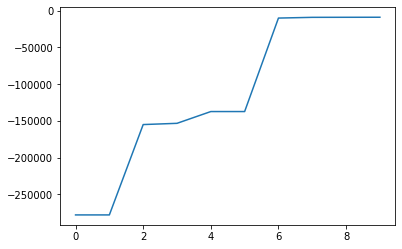

In [141]:
fig,ax = plt.subplots()
ax.plot(range(len(opti_logp)), opti_logp)

In [142]:
print(start)

{'mean_lc': array(0.), 'mean_rv': array(0.), 'u1_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'u2_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'log_M1': array(0.), 'log_R1': array(0.), 'log_k': array(0.), 'log_q': array(0.), 'log_s': array(0.), 'b_impact__': array(1.09861229), 'log_period': array(2.03982763), 't0': array(1.4268), 'ecs_unitdisk+interval__': array([2.e-05, 2.e-05]), 'sigma_lc_log__': array(0.), 'sigma_gp_log__': array(-0.69314718), 'rho_gp_log__': array(1.60943791), 'sigma_rv_log__': array(0.), 'sigma_rv_gp_log__': array(0.), 'rho_rv_gp_log__': array(0.69314718)}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


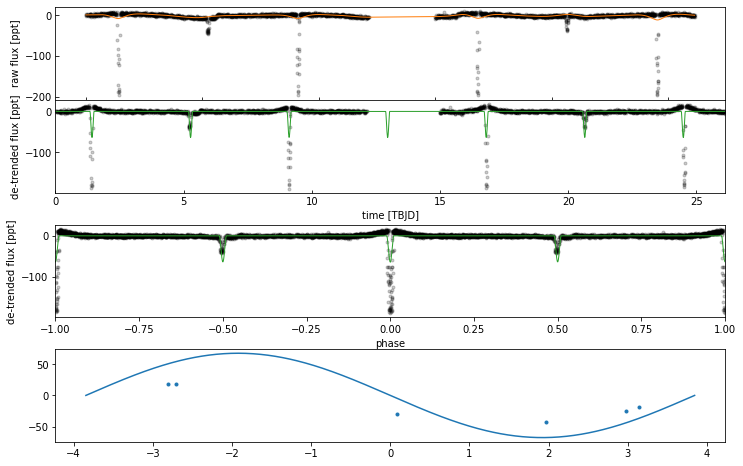

In [143]:
def plot_diagnostic_plots(soln, extras, mask):
    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    t_lc_pred = np.linspace(x.min(), x.max(), 3000)
    
    
    try:
        period = soln['period']
    except:
        period = np.exp(soln['log_period'])

    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 500)
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](t_lc_pred), soln)
            - soln["mean_lc"]
        )

#         y_rv_mod = (
#             pmx.eval_in_model(extras['gp_rv_pred'], soln) + soln['mean_rv']
#         )
        y_rv_mod = pmx.eval_in_model(
            extras['model_rv'](x_phase+t0), soln
        ) + soln['mean_rv']
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)



    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(extras["x"][mask], extras["y"][mask], "k.", alpha=0.2)
    ax1.plot(extras["x"][mask], gp_pred[mask], color="C1", lw=1)
    ax2.set_xlim(extras["x"].min(), extras["x"].max())

    ax2.plot(extras["x"][mask], extras["y"][mask] - gp_pred, "k.", alpha=0.2)
    ax2.plot(t_lc_pred, lc, color="C2", lw=1)
    ax2.set_xlim(extras["x"].min(), extras["x"].max())

    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"][mask] - soln["t0"]) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[mask][inds], extras["y"][mask][inds] - gp_pred[mask][inds], "k.", alpha=0.2)
    ax3.plot(x_fold[mask][inds] - 1, extras["y"][mask][inds] - gp_pred[mask][inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (t_lc_pred - soln["t0"]) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = (x_rv - t0 + 0.5*period) % period - 0.5*period
    ax4.plot(x_phase, y_rv_mod - mean, "C0")
    ax4.plot(x_rv_fold, y_rv - mean, ".", label='RV obs')
    
plot_diagnostic_plots(start, extras, mask=None)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


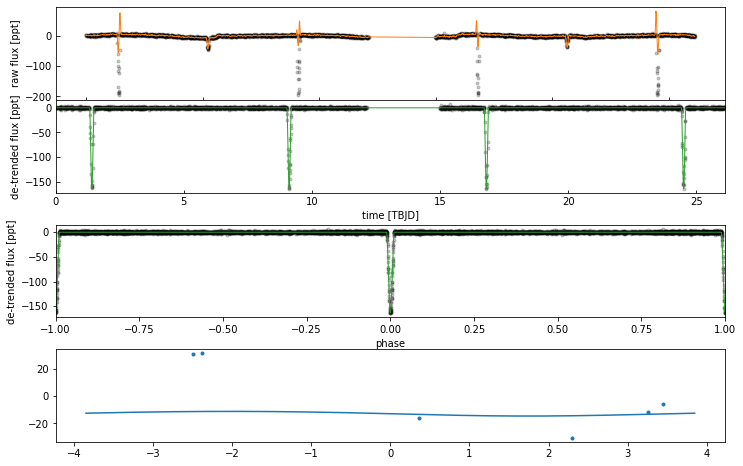

In [144]:
plot_diagnostic_plots(map_soln, extras, mask=None)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


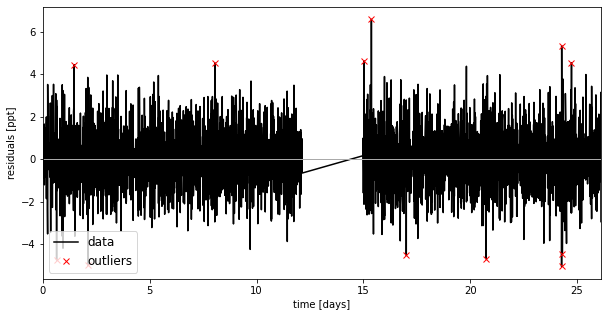

In [79]:
with model:
    mod = pmx.eval_in_model(
        extras['model_lc'](extras['x']) + extras['gp_lc_pred'],
        map_soln,
    )
    
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

message: Optimization terminated successfully.
logp: -8835.1856818356 -> -8735.821174955345


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

message: Optimization terminated successfully.
logp: -8735.821174955345 -> -8735.821174955345


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

message: Optimization terminated successfully.
logp: -8735.821174955345 -> -8689.06768397389
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot cons

message: Desired error not necessarily achieved due to precision loss.
logp: -8689.06768397389 -> -8609.363174697653
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.

message: Optimization terminated successfully.
logp: -8609.363174697653 -> -8605.617374160372


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

message: Optimization terminated successfully.
logp: -8605.617374160372 -> -8602.15850987


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

message: Optimization terminated successfully.
logp: -8602.15850987 -> -8602.126805993043


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.

message: Optimization terminated successfully.
logp: -8602.126805993043 -> -8419.60853618948
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: {self.__class__.__name__ }{{{self.len_splits}}}.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scala

message: Optimization terminated successfully.
logp: -8419.60853618948 -> -8417.29981716107
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot const

message: Desired error not necessarily achieved due to precision loss.
logp: -8417.29981716107 -> -8417.299816989062
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.

message: Desired error not necessarily achieved due to precision loss.
logp: -8417.299816989062 -> -8413.692142931197


3433 3421


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


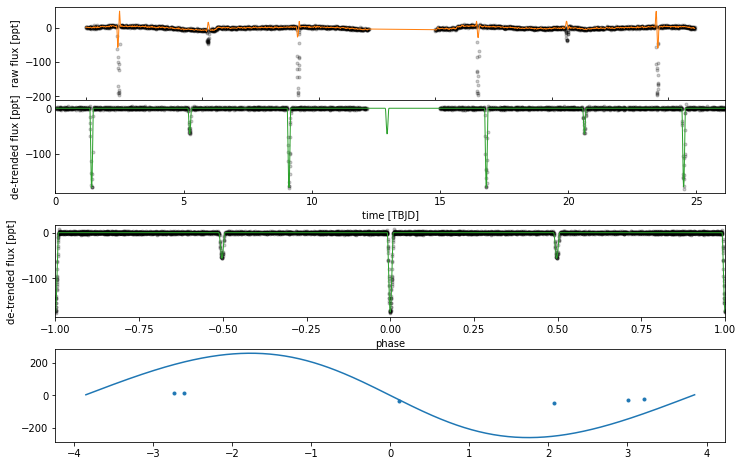

In [80]:
model, map_soln, extras, start, opti_logp = build_model(mask, map_soln)
print(len(mask), len(extras['x']))
plot_diagnostic_plots(map_soln, extras, mask=None)
plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_lightcurves_w_model_after_outlier_removal_w_s1_params.png", dpi=150, bbox_inches='tight')

In [81]:
with model:
    trace = pm.sample(
        tune=100,
        draws=50,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=4,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136681, 261136682,261136683,261136684],
        init='adapt_full'
    )

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

Sampling 4 chains for 100 tune and 50 draw iterations (400 + 200 draws total) took 208 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot c

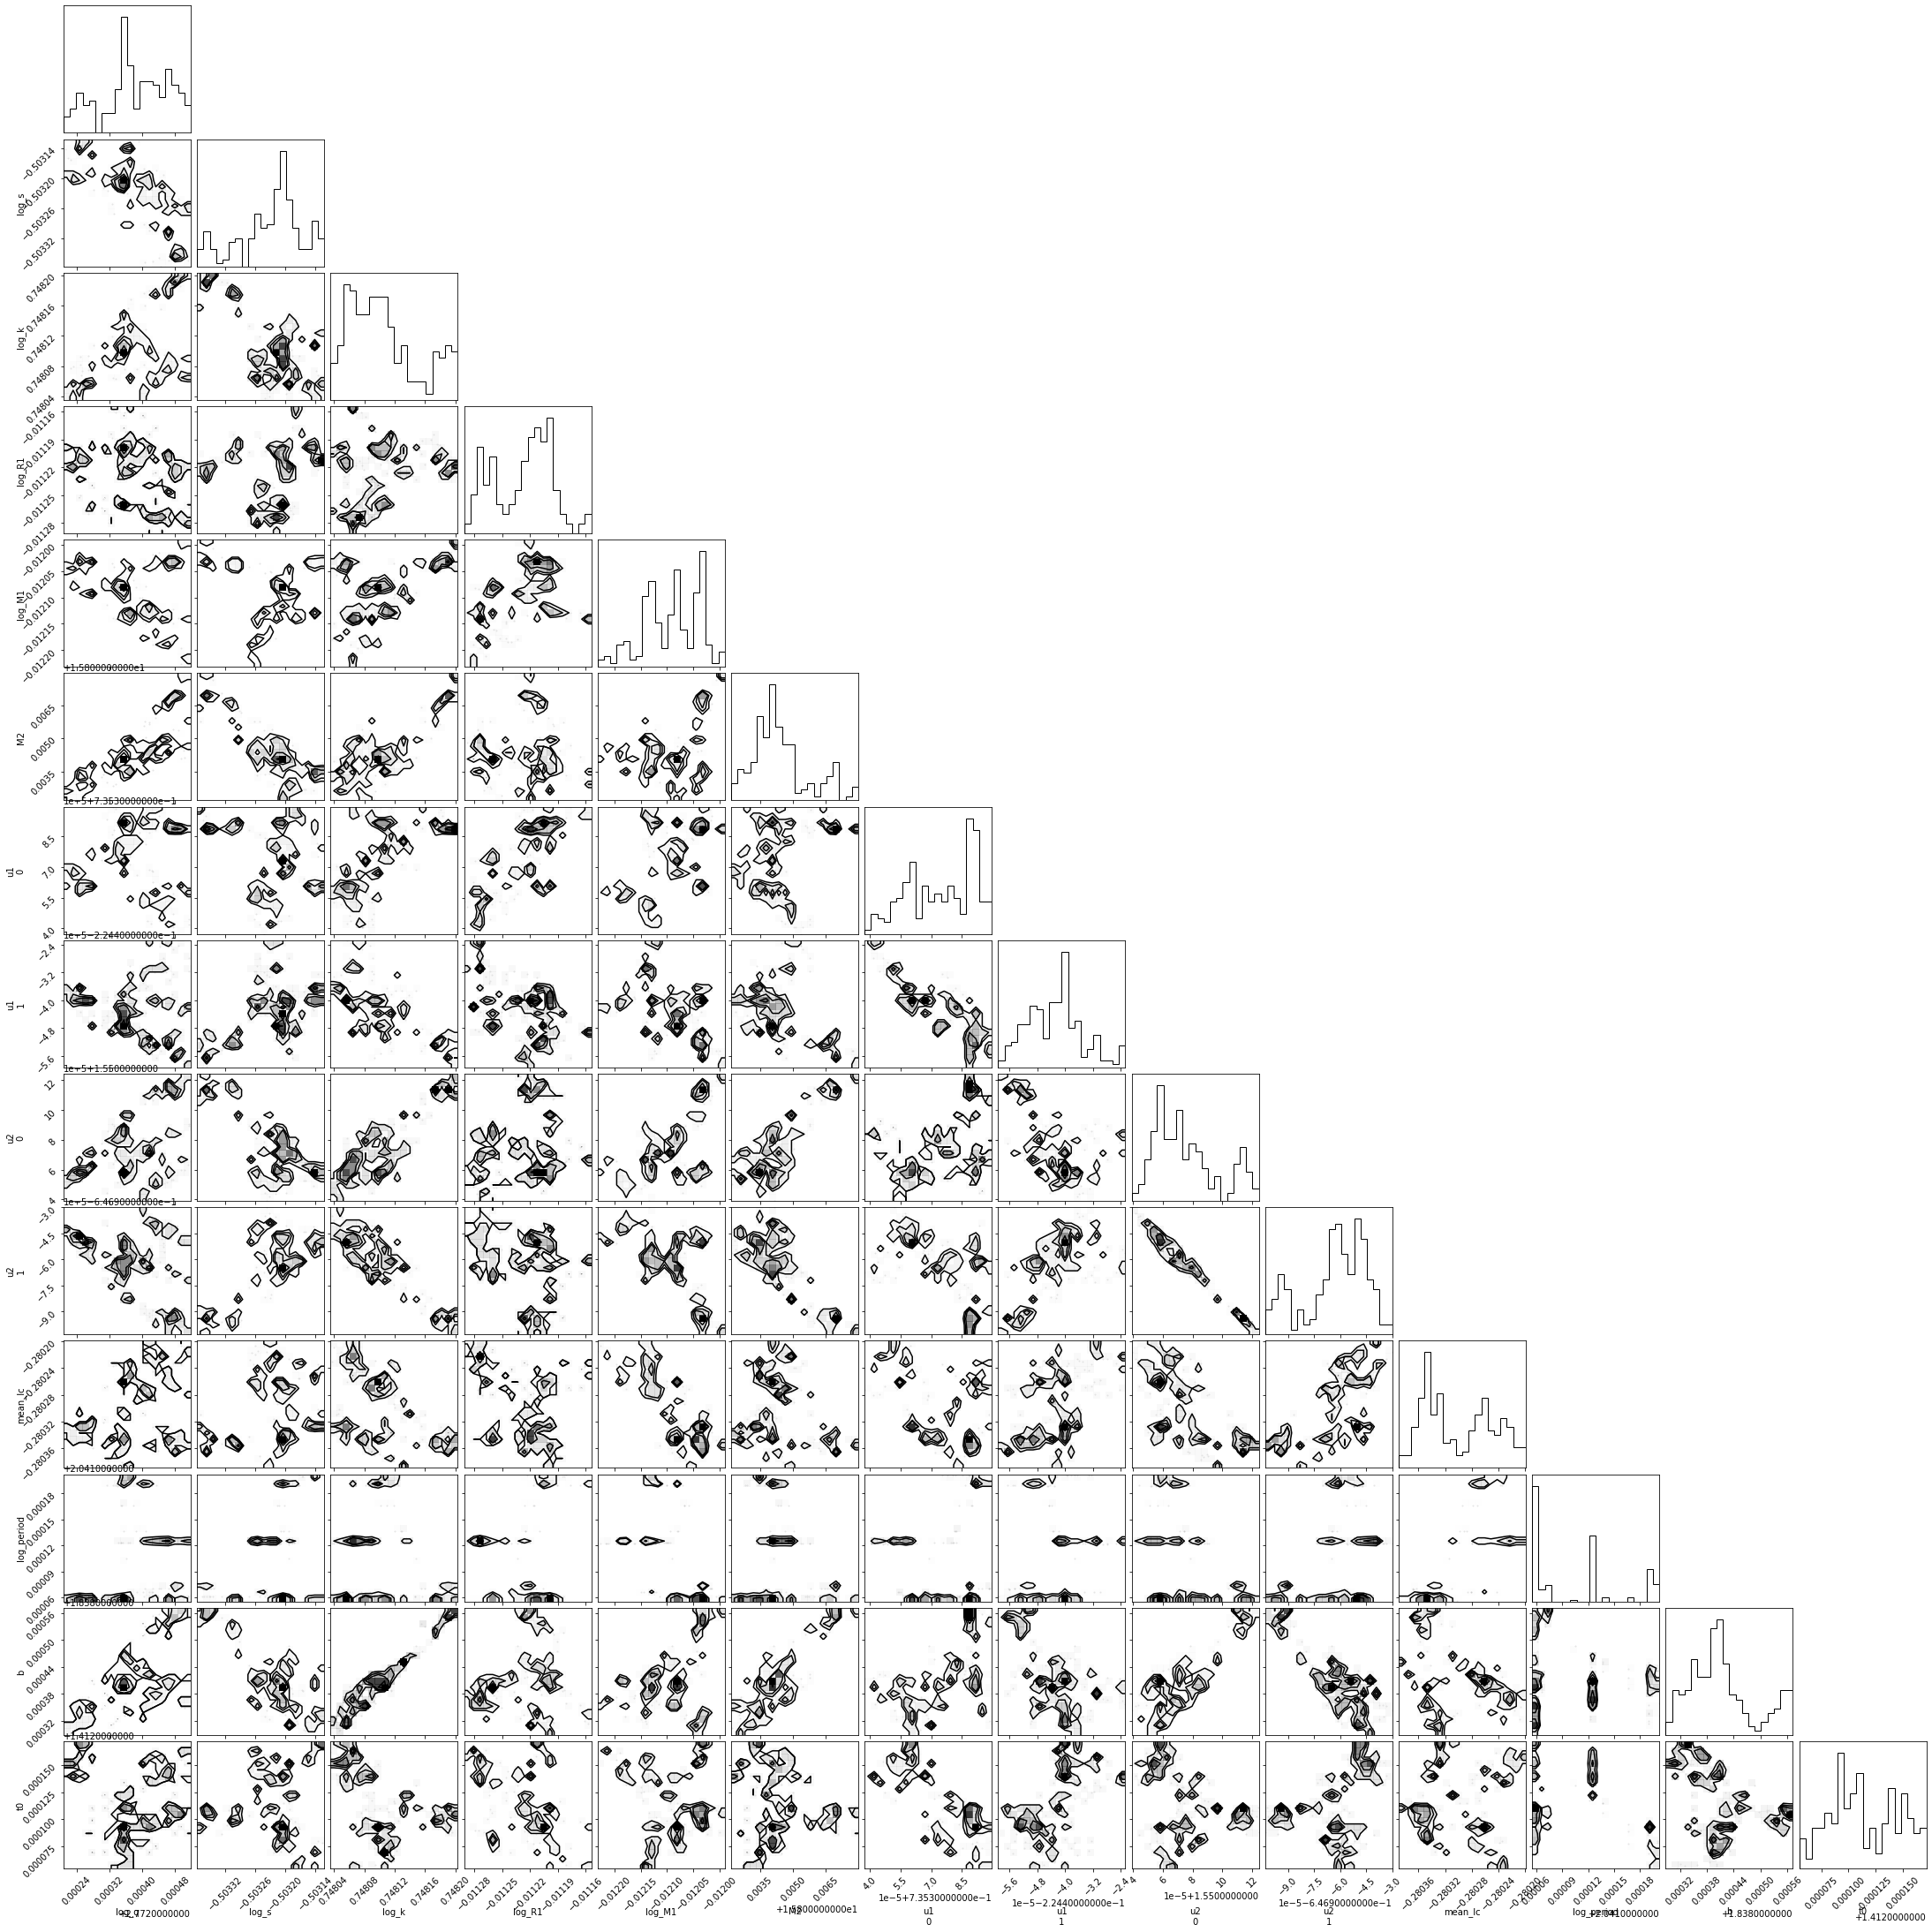

In [82]:
_ = corner(trace, var_names=['log_q','log_s','log_k','log_R1','log_M1','M2','u1','u2','mean_lc','log_period','b','t0'])

In [83]:
az.summary(trace, var_names=['log_q','log_s','log_k','log_R1','log_M1','u1','u2','mean_lc','log_period','b','t0'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_q,2.772,0.0,2.772,2.773,0.0,0.0,6.0,21.0,2.12
log_s,-0.503,0.0,-0.503,-0.503,0.0,0.0,5.0,20.0,2.48
log_k,0.748,0.0,0.748,0.748,0.0,0.0,6.0,27.0,2.27
log_R1,-0.011,0.0,-0.011,-0.011,0.0,0.0,6.0,26.0,2.15
log_M1,-0.012,0.0,-0.012,-0.012,0.0,0.0,5.0,13.0,2.81
u1[0],0.735,0.0,0.735,0.735,0.0,0.0,6.0,18.0,2.26
u1[1],-0.224,0.0,-0.224,-0.224,0.0,0.0,7.0,19.0,1.79
u2[0],1.550,0.0,1.550,1.550,0.0,0.0,6.0,26.0,2.00
u2[1],-0.647,0.0,-0.647,-0.647,0.0,0.0,6.0,16.0,2.15
mean_lc,-0.280,0.0,-0.280,-0.280,0.0,0.0,6.0,27.0,2.27


<xarray.DataArray 'u1' (u1_dim_0: 2, sample: 1000)>
array([[ 1.68284063,  1.72654232,  1.64943587, ...,  1.45793275,
         1.5699892 ,  1.52040341],
       [-0.74801033, -0.80973432, -0.77281209, ..., -0.71788257,
        -0.76755433, -0.73438981]])
Coordinates:
  * u1_dim_0  (u1_dim_0) int64 0 1
  * sample    (sample) MultiIndex
  - chain     (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  - draw      (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
period  : 7.689272657316044
t0  : 1.4259190894142981
ecc  : 0.09782638021508215
omega  : -1.5937251011573978
b  : 0.7885123731716384
R1  : 0.44273306627127046
M1  : 0.04245680146995896
R2  : 0.22065485800707413
M2  : 0.07529905212935734
u1  : [ 1.68363663 -0.78867734]
u2  : [0.43116307 0.25729057]
s  : 0.12312815979677552


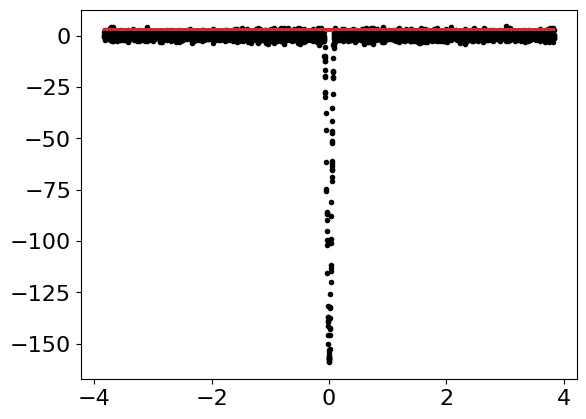

In [56]:
xo.utils.docs_setup()
flat_samps = trace.posterior.stack(sample=("chain", "draw"))
print(flat_samps['u1'])

# Compute the GP prediction
with model:
    gp_pred = (
        pmx.eval_in_model(extras["gp_lc_pred"], map_soln) + map_soln["mean_lc"]
    )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])
ecc = np.median(flat_samps['ecc'])
omega = np.median(flat_samps['omega'])
b = np.median(flat_samps['b'])
R1 = np.median(flat_samps['R1'])
R2 = np.median(flat_samps['R2'])
M1 = np.median(flat_samps['M1'])
M2 = np.median(flat_samps['M2'])
u1 = np.median(flat_samps['u1'],axis=-1)
u2 = np.median(flat_samps['u2'],axis=-1)
s = np.median(flat_samps['s'])
mean_lc = np.median(flat_samps['mean_lc'])

vars_of_interest = ["period", "t0",
                    "ecc", "omega","b",
                    "R1","M1","R2","M2",
                    "u1","u2",'s']

for sampl_meds in vars_of_interest:
    print(sampl_meds," :",np.median(flat_samps[sampl_meds],axis=-1))

orbit = xo.orbits.KeplerianOrbit(
    period=p,
    t0=t0,
    ecc=ecc,
    omega=omega,
    b=b,
    r_star=R2,
    m_star=M2,
    m_planet=M1,
)


light_curve = (
    xo.SecondaryEclipseLightCurve(u1, u2, s)
    .get_light_curve(orbit=orbit, r=R1, t=x[mask], texp=texp)
).eval()

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_pred, ".k", label="data", zorder=-1000)
plt.plot(x_fold, light_curve-mean_lc, c='C3')